<a href="https://colab.research.google.com/github/Dhlih/Analisis-Komen-Negatif/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("indonesian"))

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ahmadizzan/netifier/master/data/raw/train.csv")

In [ ]:
df.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0


In [ ]:
# data preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

df["original_text"] = df["original_text"].str.lower()

for i in range(len(df)):
    text = df.loc[i, "original_text"]
    sub = re.sub(r"[^a-z\s]", " ", str(text).lower())
    df.loc[i, "original_text"] = sub

vectorizer = TfidfVectorizer()

In [ ]:
df[:10]

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik
0,quote jessepinkman a ac d b f b e...,kaskus,0,0,0,1
1,verosvante kita aja nitizen yang pada kepo t...,instagram,0,0,0,0
2,sidangahok smg sipenista agama n ateknya mat...,twitter,0,1,1,1
3,bolususulembang jkt barusan baca undang ini ...,instagram,0,0,0,0
4,bikin anak mulu lu nof nkaga mikir apa kasian...,kaskus,0,0,0,0
5,itu membuktikan bahwa rakyat malaysia anti cin...,kaskus,0,1,0,1
6,basherrl heh kontol jan sok pemes lu di rp ...,twitter,1,0,0,1
7,ongbaotek eh memek diem lo pala lo kaya konto...,twitter,1,0,0,0
8,mungkin akibat memakai gorden di pala menghamb...,kaskus,0,0,0,0
9,e kaka nona yg paling bodoh dan goblok manokwa...,twitter,0,0,0,0


In [ ]:
examp = df["pornografi"][:10]
examp.value_counts()

,count
pornografi,
0,8
1,2


<Axes: >

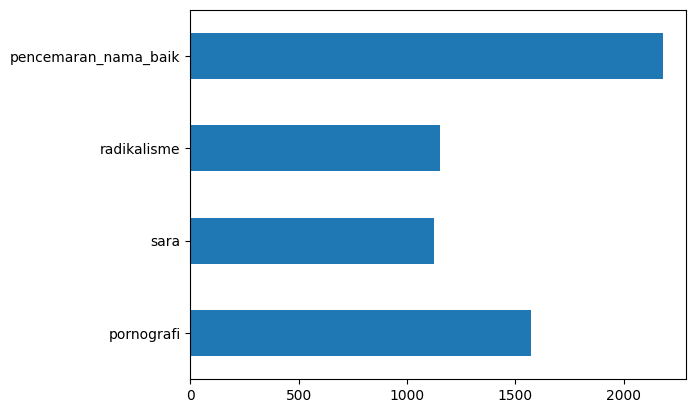

In [ ]:
df[['pornografi','sara','radikalisme','pencemaran_nama_baik']].sum().plot(kind="barh")

<Axes: ylabel='source'>

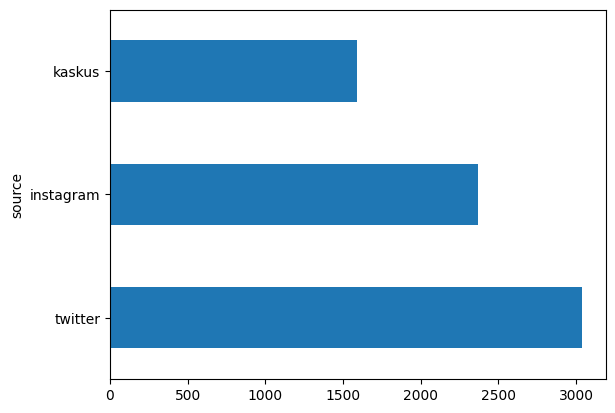

In [ ]:
counts = df["source"].value_counts()
counts.plot(kind="barh")

<Axes: xlabel='source'>

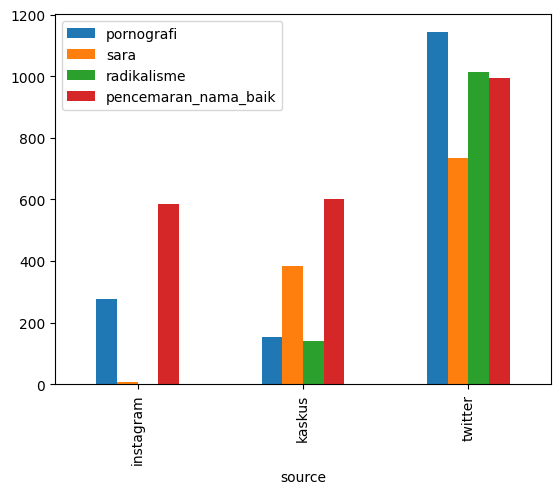

In [ ]:
grouped = df.groupby('source')[["pornografi", "sara", "radikalisme", "pencemaran_nama_baik"]].sum()
grouped.plot(kind='bar')

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X = vectorizer.fit_transform(df["original_text"])

y = df[["pornografi", "sara", "radikalisme", "pencemaran_nama_baik"]]

model = LogisticRegression(
        C=3.14,
        class_weight='balanced',
        solver='lbfgs',
        max_iter=2000)

ovr = OneVsRestClassifier(model)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {
    'estimator__C': uniform(0.1, 10),          # regularisasi
    'estimator__class_weight': [None, 'balanced'],
    'estimator__solver': ['lbfgs', 'liblinear']  # solver cocok buat small/medium dataset
}

# --- RandomizedSearchCV ---
search = RandomizedSearchCV(
    ovr,
    param_distributions=param_distributions,
    n_iter=10,             # coba 10 kombinasi random
    cv=3,                  # 3-fold cross-validation
    scoring='f1_micro',    # atau 'f1_macro'
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# --- jalankan search ---
search.fit(X, y)

# --- hasil terbaik ---
print("Best score:", search.best_score_)
print("Best params:", search.best_params_)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=3.14,
                                                 class_weight='balanced',
                                                 max_iter=2000))

In [ ]:
from sklearn.metrics import f1_score, classification_report

y_pred = ovr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       330
           1       0.65      0.71      0.68       232
           2       0.76      0.83      0.79       218
           3       0.74      0.70      0.72       465

   micro avg       0.77      0.75      0.76      1245
   macro avg       0.78      0.76      0.76      1245
weighted avg       0.78      0.75      0.76      1245
 samples avg       0.44      0.43      0.43      1245



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import joblib

joblib.dump(ovr, "model1.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")